In [2]:
#@formatter:off
import re
import numpy as np
import pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  MinMaxScaler
from sklearn.svm import SVC


pandas.options.display.max_rows = 100
pandas.options.display.max_columns = 100
%matplotlib inline
sns.set_theme(style='whitegrid')
#@formatter:on

In [3]:
def get_tags(column, tags):
    column.fillna('', inplace=True)
    output = pd.Series(index=column.index, dtype=object)
    for tag in tags:
        output[column.str.contains(tag)] = tag
    return output


def extend_feature_names(origin_column, new_features):
    if isinstance(new_features, str):
        return [origin_column + '_' + str(new_features)]
    else:
        return [origin_column + '_' + str(feature) for feature in new_features]


def extend_intervals_borders(intervals):
    leftmost = pd.Interval(-np.inf, intervals[0].right)
    rightmost = pd.Interval(intervals[-1].left, np.inf)
    return pd.IntervalIndex([leftmost, *intervals[1:-1], rightmost])


class TagAdder(BaseEstimator):
    def __init__(self, tags, column, tag_column, na_value=None):
        self.tags = tags
        self.column = column
        self.tag_column = tag_column
        self.na_value = na_value

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df = df.copy()
        df[self.tag_column] = get_tags(df[self.column], self.tags)
        if self.na_value is not None:
            df[self.tag_column].fillna(self.na_value, inplace=True)
        return df


# TODO quantile choice for each column
class DfBiner(BaseEstimator, TransformerMixin):
    def __init__(self, col_bins, quantile=False):
        self.col_bins = col_bins
        self.cut_func = pd.qcut if quantile else pd.cut
        self.col_bins_fitted = {}

    def fit(self, df, y=None):
        for col, bins in self.col_bins.items():
            self.col_bins_fitted[col] = extend_intervals_borders(
                self.cut_func(df[col], bins, duplicates='drop').dtype.categories)
        return self

    def transform(self, df, y=None):
        df = df.copy()
        for col, bins in self.col_bins_fitted.items():
            df[col] = pd.cut(df[col], bins).astype(str)
        return df


class TitleReplacer(BaseEstimator):
    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df = df.copy()
        df['Title'] = df.apply(self.__replace_title, axis=1)
        return df

    def __replace_title(self, row):
        title = row['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title == 'Dr':
            if row['Sex'] == 'Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title


class TitanicFeatureFixer(BaseEstimator):
    def __init__(self, remove_list):
        self.remove_list = remove_list

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df = df.copy()
        mode_imputer = SimpleImputer(strategy='most_frequent')
        median_imputer = SimpleImputer(strategy='median')
        df['Embarked'] = mode_imputer.fit_transform(np.c_[df['Embarked']])
        df[['Age', 'Fare']] = median_imputer.fit_transform(df[['Age', 'Fare']])
        df['FamilySize'] = df['SibSp'] + df['Parch']
        df['AgeClass'] = df['Age'] * df['Pclass']
        df['FarePerPerson'] = df['Fare'] / (df['FamilySize'] + 1)
        df.drop(self.remove_list, axis=1, inplace=True)
        return df


class AutoEncoder(BaseEstimator, TransformerMixin):  # TODO extra categorical features
    def __init__(self, extra_cat_features=()):
        self.extra_cat_features = extra_cat_features
        self.__clean_attributes()

    def fit(self, df, y=None):
        self.__init_attributes(df)
        self.categories_.extend(self.__numeric.copy())
        for col in self.__binary:
            encoder = OrdinalEncoder()
            encoder.fit(np.c_[df[col]])
            self.categories_.extend(extend_feature_names(col, encoder.categories_[0][0]))
            self.__encoders.append(encoder)
        for col in self.__categorical:
            encoder = OneHotEncoder(sparse=False)
            encoder.fit(np.c_[df[col]])
            extended_features = extend_feature_names(col, encoder.categories_[0])
            self.categories_.extend(extended_features)
            self.__encoders.append(encoder)
        return self

    def transform(self, df, y=None):
        features = [df[self.__numeric].to_numpy()]
        for col, enc in zip(self.__binary + self.__categorical, self.__encoders):
            feature = enc.transform(np.c_[df[col]])
            features.append(feature)
        return np.concatenate([*features], axis=1)

    def __init_attributes(self, df):
        self.__clean_attributes()
        for col in df.columns:
            print(col)
            if np.issubdtype(df[col], np.number) and col not in self.extra_cat_features:
                self.__numeric.append(col)
            else:
                if len(df[col].unique()) == 2:
                    self.__binary.append(col)
                else:
                    self.__categorical.append(col)

    def __clean_attributes(self):
        self.__numeric = []
        self.__binary = []
        self.__categorical = []
        self.__encoders = []
        self.categories_ = []

In [4]:
def which_contains(self, regexp):
    if not isinstance(regexp, str):
        regexp = iterable_to_regexp(regexp)
    return self.loc[self.str.contains(regexp)]


def iterable_to_regexp(entries):
    return '|'.join([re.escape(entry) for entry in entries])


pd.Series.which_contains = which_contains

In [5]:
train_df = pd.read_csv('data/titanic_train.csv')
test_df = pd.read_csv('data/titanic_test.csv')
y_train = train_df.Survived.to_numpy()
train_df.drop(columns='Survived', inplace=True)
train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
list_of_list_of_names = train_df.Name.str.split().values
words = [word for lst in list_of_list_of_names for word in lst]
titles = pd.Series(words).which_contains('\\.').str.replace('\\.', '').unique().tolist()
for i in ['L', 'Lady', 'Sir']:
    titles.remove(i)
print(titles)

decks = train_df.Cabin.str[0].unique()[1:]
print(decks)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']
['C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [7]:
full_pipeline = Pipeline([
    ('title_tagger', TagAdder(titles, 'Name', 'Title')),
    ('title_replacer', TitleReplacer()),
    ('deck_tagger', TagAdder(decks, 'Cabin', 'Deck', 'U')),
    ('feature_fixer', TitanicFeatureFixer(['Name', 'Ticket', 'Cabin', 'PassengerId'])),
    ('df_biner', DfBiner({'Age': 8}, quantile=True)),
    ('auto_encoder', AutoEncoder(extra_cat_features=['Pclass'])),
    ('minmax_scaler', MinMaxScaler())
])

X_train = full_pipeline.fit_transform(train_df)
X_test = full_pipeline.transform(test_df)
print(full_pipeline['auto_encoder'].categories_)

Pclass
Sex
Age
SibSp
Parch
Fare
Embarked
Title
Deck
FamilySize
AgeClass
FarePerPerson
['SibSp', 'Parch', 'Fare', 'FamilySize', 'AgeClass', 'FarePerPerson', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_(-inf, 17.0]', 'Age_(17.0, 22.0]', 'Age_(22.0, 27.0]', 'Age_(27.0, 28.0]', 'Age_(28.0, 29.0]', 'Age_(29.0, 35.0]', 'Age_(35.0, 45.0]', 'Age_(45.0, inf]', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U']


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7ac9ffe20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7ac9ab700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7ac991dc0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe7ac9abe20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7ac9b51f0>,
 'means': []}

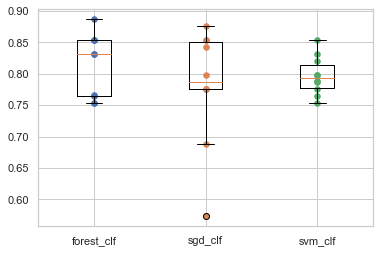

In [8]:
forest_clf = RandomForestClassifier(random_state=228)
sgd_clf = SGDClassifier(random_state=228)  # TODO tune hyperparams
svm_clf = SVC(gamma='auto', random_state=228)

cv = 10
models = [forest_clf, sgd_clf, svm_clf]
scores = [cross_val_score(model, X_train, y_train.ravel(), cv=cv, n_jobs=-1) for model in models]
for i in range(len(scores)):
    plt.scatter([i + 1] * cv, scores[i], s=30)
plt.boxplot(scores, labels=['forest_clf', 'sgd_clf', 'svm_clf'])
# cross_val_score(forest_clf, X_train, y_train.ravel(), cv=5, n_jobs=-1, scoring='accuracy').mean()

In [9]:
forest_clf.fit(X_train, y_train.ravel())
prediction = forest_clf.predict(X_test)
submission = pd.DataFrame({'Survived': prediction}, index=test_df['PassengerId'])
print(submission)
submission.to_csv('data/submission.csv')

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 1
896                 1
...               ...
1305                0
1306                1
1307                0
1308                0
1309                1

[418 rows x 1 columns]


In [10]:
train_df.Cabin.head(50)

0             NaN
1             C85
2             NaN
3            C123
4             NaN
5             NaN
6             E46
7             NaN
8             NaN
9             NaN
10             G6
11           C103
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            D56
22            NaN
23             A6
24            NaN
25            NaN
26            NaN
27    C23 C25 C27
28            NaN
29            NaN
30            NaN
31            B78
32            NaN
33            NaN
34            NaN
35            NaN
36            NaN
37            NaN
38            NaN
39            NaN
40            NaN
41            NaN
42            NaN
43            NaN
44            NaN
45            NaN
46            NaN
47            NaN
48            NaN
49            NaN
Name: Cabin, dtype: object